C:\Users\lamph\AppData\Local\Temp\ipykernel_18424\1910212506.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})


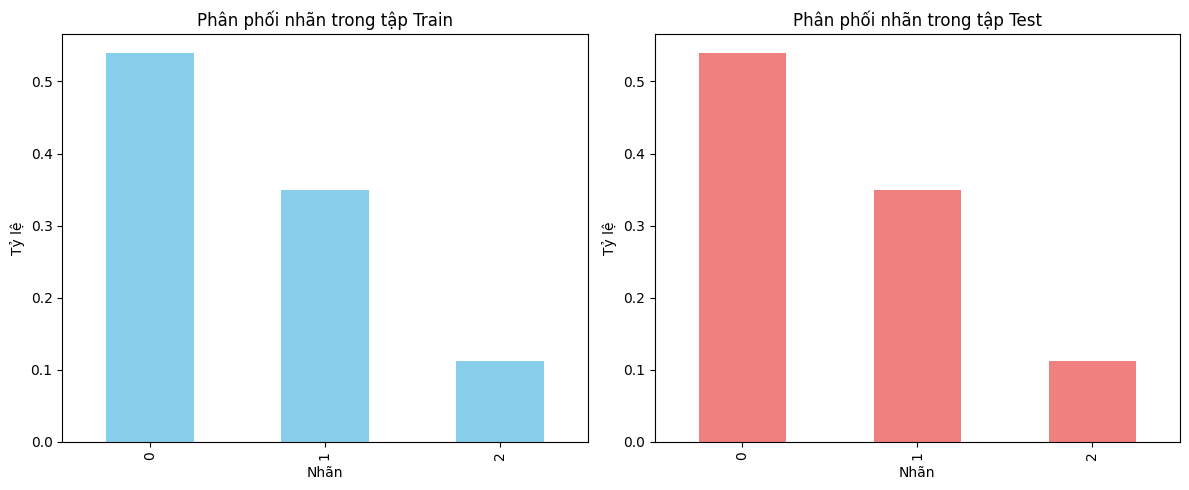

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Đường dẫn đến file dữ liệu gốc
file_path = 'diabetic_data.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(file_path)

# Mã hóa cột 'readmitted' (đảm bảo dữ liệu có thể sử dụng cho bài toán phân loại)
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})

# Chia dữ liệu thành tập train (80%) và test (20%) sao cho tỷ lệ nhãn đều nhau
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['readmitted'])

# Đường dẫn để lưu dữ liệu
train_path = '/train_data.csv'
test_path = '/test_data.csv'

# Lưu dữ liệu train và test thành file CSV
train_data.to_csv(train_path, index=False)
test_data.to_csv(test_path, index=False)

# Xác nhận rằng tệp đã được lưu thành công
print(f'Train file saved to: {train_path}')
print(f'Test file saved to: {test_path}')

# Hiển thị biểu đồ phân phối của các nhãn trong tập train và test
plt.figure(figsize=(12, 5))

# Biểu đồ phân phối cho tập train
plt.subplot(1, 2, 1)
train_data['readmitted'].value_counts(normalize=True).plot(kind='bar', color='skyblue')
plt.title('Phân phối nhãn trong tập Train')
plt.xlabel('Nhãn')
plt.ylabel('Tỷ lệ')

# Biểu đồ phân phối cho tập test
plt.subplot(1, 2, 2)
test_data['readmitted'].value_counts(normalize=True).plot(kind='bar', color='lightcoral')
plt.title('Phân phối nhãn trong tập Test')
plt.xlabel('Nhãn')
plt.ylabel('Tỷ lệ')

plt.tight_layout()
plt.show()


In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

#  Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Readmission Prediction") \
    .getOrCreate()

# Đọc dữ liệu từ tệp CSV
file_path = 'diabetic_data.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Xử lý dữ liệu

# Loại bỏ các cột không cần thiết
df = df.drop('encounter_id', 'patient_nbr', 'payer_code', 'weight')

# Thay thế các giá trị '?' bằng 'unknown'
df = df.replace('?', 'unknown')

# Ép kiểu các cột phân loại về string
categorical_columns = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 
                       'medical_specialty', 'change', 'diabetesMed']
for col_name in categorical_columns:
    df = df.withColumn(col_name, col(col_name).cast("string"))

# Thay đổi cột readmitted thành số (NO -> 0, >30 -> 1, <30 -> 2)
df = df.withColumn('readmitted', 
                   when(col('readmitted') == 'NO', 0)
                   .when(col('readmitted') == '>30', 1)
                   .when(col('readmitted') == '<30', 2)
                   .cast('double'))

#  Áp dụng StringIndexer và OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='skip') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_columns]

#  Tạo feature vector từ tất cả các cột
feature_columns = [col + "_encoded" for col in categorical_columns] + [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_outpatient', 'number_emergency', 
    'number_inpatient', 'number_diagnoses'
]

# Tạo vector features từ các cột đầu vào
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Khởi tạo mô hình RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol="readmitted", featuresCol="features", 
                                       predictionCol="prediction", numTrees=100)

# Tạo pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf_classifier])

#Tách dữ liệu thành tập train và test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

#Huấn luyện mô hình
model = pipeline.fit(train_data)

#Dự đoán trên tập test
predictions = model.transform(test_data)

# Hiển thị một số dòng của predictions
predictions.select("readmitted", "prediction", "probability").show(5)

# Đánh giá mô hình
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="readmitted", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Accuracy = {accuracy}")

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="readmitted", predictionCol="prediction", metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score = {f1_score}")


+----------+----------+--------------------+
|readmitted|prediction|         probability|
+----------+----------+--------------------+
|       1.0|       0.0|[0.63268472873185...|
|       1.0|       0.0|[0.52375056040294...|
|       0.0|       0.0|[0.62776818017051...|
|       1.0|       0.0|[0.52629296877173...|
|       1.0|       0.0|[0.62221842069565...|
+----------+----------+--------------------+
only showing top 5 rows

Accuracy = 0.5612436874938113
F1-Score = 0.442826517843978
